In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
# import datetime as dt
from datetime import datetime

import time
# import datetime.datetime



from keras import layers
from keras import models
# from keras import optimizers
from tensorflow.keras import optimizers

from keras.applications.densenet import DenseNet121, DenseNet169
#from keras.applications.nasnet import NASNetLarge
# from keras_efficientnets import EfficientNetB7
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras import backend as K

tf.set_random_seed(1234)
random.seed(100)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

from ABNmodules import *




loss_function = 'categorical_crossentropy'
activation_function = 'softmax'


/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [2]:
def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [3]:
# n=3, kernelsize= 10, epoch 100, best_acc = 0.613

model_dir = '/home/taejoon/PhysioNetChallenge/results_20200525_0'

bestmodel = 'ECG_ABN_E77L0.64'
model = get_model((None, 12), 9, n=7)


model.compile(loss=[loss_function, loss_function],
              
              
              optimizer=optimizers.Adam(lr=1e-5),
          
              metrics=[score_f1])


# model.load_weights(os.path.join(model_dir, bestmodel))


# model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.summary()
model.load_weights(os.path.join(model_dir, bestmodel))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, 12)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 256)    9216        input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 256)    1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        #print(clip_file.shape)
        #clip_file = tmp_file[:minimum_len]
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes

def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final): 
    loss=[]
    acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_tmp[0])
        acc.append(train_tmp[1])
        f1.append(train_tmp[2])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    f1 = np.mean(np.array(f1))
    return loss, acc, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            mel_files.append(clip_file)
        mel_files = np.asarray(mel_files)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        pred = np.argmax(logit)
        label = np.argmax(get_labels(input_directory, file, class2index))
        #f1 = f1_score(label, logit)
        #print(pred, label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        #total_f1 += f1
    final_acc = total_acc / i
    #final_f1 = total_f1 / i
    return final_acc#, final_f1

batch_size = 32
minimum_len = 2880

epochs = 1000
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'
rootdir = '../'
date = datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results_'+date+'_0')
if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
    os.mkdir(results_directory)
        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
index2class = {y:x for x,y in class2index.items()}    
classes_orig= [x.replace('.mat', '.hea') for x in input_file_names] # total subjects
classes_multi, _, _ = searching_overlap(input_directory,class2index, input_file_names)
classes_single = [x for x in classes_orig if x not in classes_multi]
classes_single = [x.replace('.hea', '.mat') for x in classes_single]

# double-checking if classes_single have single-label
a, b, c  = searching_overlap(input_directory,class2index,classes_single)

# we can safely use classes_single as input_file_names
input_file_names = classes_single
random.shuffle(input_file_names)
np.shape(input_file_names)

x_mean_all = []
x_std_all = []

for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    #print(x_mean)
    x_mean_all.append(x_mean)
    x_std_all.append(x_mean)
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)
print(x_mean_final)

data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

[-2.24290386e-03 -4.58280585e-05  4.31697309e-03 -3.00174693e-03
 -2.36609229e-04  1.28997408e-03  2.17347589e-04 -7.99152384e-04
 -3.42993744e-03 -1.69711686e-03  1.27138164e-03  1.94670545e-03]
(3840,) (1280,) (1281,)


In [24]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('activation_84').output])




In [ ]:
# model2 = Model(inputs=model.input,
#               outputs=[model.output, model.get_layer('attention_branch_att_sigmoid_1').output])


In [7]:
file=data_train[0]
tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
clip_file = block_feature(tmp_file, minimum_len)

clip_file -= x_mean_final
clip_file /= x_std_final
clip_file.shape

preprocessed_input=clip_file

preprocessed_input.shape


(2880, 12)

In [53]:
file


'A2769.mat'

In [14]:
preprocessed_input = np.reshape(preprocessed_input, (1,minimum_len,12))

preprocessed_input.shape


(1, 2880, 12)

In [25]:
outputs = model.predict(preprocessed_input)


In [27]:
outputs[2].shape

(1, 1440, 1)

In [23]:
att_map = outputs[2]


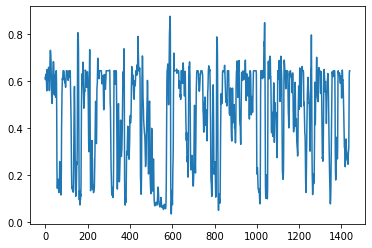

In [29]:
plt.plot(np.squeeze(outputs[2]))



In [32]:
import cv2
resize_att = cv2.resize(outputs[2], (2880,1))
resize_att.shape


(1, 2880)

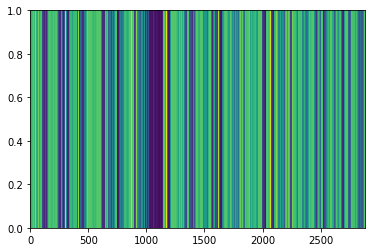

In [34]:
import seaborn as sns
plt.pcolor(resize_att)


In [38]:
dot = np.squeeze(preprocessed_input) * np.transpose(resize_att)
dot.shape




(2880, 12)

In [71]:
dot[:,0].shape




(2880,)

In [89]:
# 정규화!!!
x_mean_all = []
x_std_all = []
x=preprocessed_input
x_mean = [np.mean(x[:,:,0]), np.mean(x[:,:,1]), np.mean(x[:,:,2]), np.mean(x[:,:,3]), np.mean(x[:,:,4]), np.mean(x[:,:,5]),
             np.mean(x[:,:,6]), np.mean(x[:,:,7]), np.mean(x[:,:,8]), np.mean(x[:,:,9]), np.mean(x[:,:,10]), np.mean(x[:,:,11])]
    
x_std = [np.std(x[:,:,0]), np.std(x[:,:,1]), np.std(x[:,:,2]), np.std(x[:,:,3]), np.std(x[:,:,4]), np.std(x[:,:,5]),
             np.std(x[:,:,6]), np.std(x[:,:,7]), np.std(x[:,:,8]), np.std(x[:,:,9]), np.std(x[:,:,10]), np.std(x[:,:,11])]
    #print(x_mean)
x_mean_all.append(x_mean)
x_std_all.append(x_std)

x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)

clip_file -= x_mean_final
clip_file /= x_std_final



dot2 = np.squeeze(clip_file) * np.transpose(resize_att)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [90]:
x_std



[2.3512761679927968e+17,
 5.832989281994417e+16,
 8.402717927415104e+16,
 nan,
 2.915255423495936e+16,
 2.7799601759179556e+16,
 2.1019095814038294e+17,
 1.3613990838622688e+17,
 7.262759003207566e+16,
 5.977899292516163e+17,
 1.3063592540064984e+17,
 3.0682138261496083e+17]

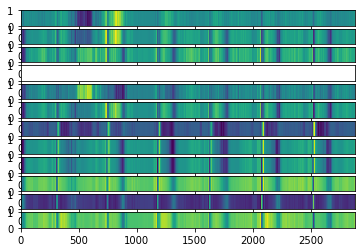

In [84]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.pcolor(np.reshape(dot2[:,i], (1,2880)))
    

In [86]:
clip_file.shape


(2880, 12)

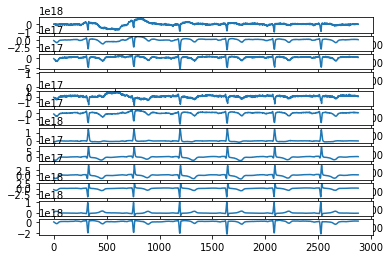

In [87]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(clip_file[:,i], (2880,1)))
    
    

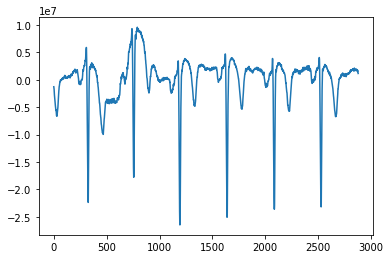

In [52]:
plt.plot(np.reshape(preprocessed_input[0,:,1],(2880,1)))

In [60]:
label = get_labels(input_directory, file, class2index)
label

[0, 0, 0, 0, 0, 0, 0, 1, 0]

In [61]:
class2index


{'AF': 0,
 'I-AVB': 1,
 'LBBB': 2,
 'Normal': 3,
 'PAC': 4,
 'PVC': 5,
 'RBBB': 6,
 'STD': 7,
 'STE': 8}